# 2. Test of models

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
from torch import Tensor
import torch.nn as nn
import torch.cuda as cuda
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Dataset
from torch.nn.parameter import Parameter

try:
    import accimage
except ImportError:
    accimage = None

import random
import copy
import time

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder

from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils

import struct
import glob
import datetime
import re

from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from PIL import Image

## Model

In [2]:
def get_k_winners(potentials, kwta=1, inhibition_radius=0, spikes=None):

    if spikes is None:
        spikes = potentials.sign()
        
    # finding earliest potentials for each position in each feature
    maximum = (spikes.size(0) - spikes.sum(dim = 0, keepdim=True)).long()    
    maximum.clamp_(0, spikes.size(0) - 1)
    values = potentials.gather(dim=0, index=maximum) # gathering values
    
    # propagating the earliest potential through the whole timesteps
    truncated_pot = spikes * values
    
    # summation with a high enough value (maximum of potential summation over timesteps) at spike positions
    v = truncated_pot.max() * potentials.size(0)
    truncated_pot.addcmul_(spikes,v)

    # summation over all timesteps
    total = truncated_pot.sum(dim=0,keepdim=True)

    total.squeeze_(0)
    global_pooling_size = tuple(total.size())
    winners = []
    
    for k in range(kwta):
        max_val,max_idx = total.view(-1).max(0)
        
        if max_val.item() != 0:
          
            # finding the 3d position of the maximum value
            max_idx_unraveled = np.unravel_index(max_idx.item(), global_pooling_size)
            
            # adding to the winners list
            winners.append(max_idx_unraveled)
            
            # preventing the same feature to be the next winner
            total[max_idx_unraveled[0],:,:] = 0
            
            # columnar inhibition (increasing the chance of leanring diverse features)
            if inhibition_radius != 0:
                rowMin,rowMax = max(0,max_idx_unraveled[-2]-inhibition_radius),min(total.size(-2),max_idx_unraveled[-2]+inhibition_radius+1)
                colMin,colMax = max(0,max_idx_unraveled[-1]-inhibition_radius),min(total.size(-1),max_idx_unraveled[-1]+inhibition_radius+1)
                total[:,rowMin:rowMax,colMin:colMax] = 0
        else:
            break
            
    return max_val.item(), max_idx_unraveled[0]

In [3]:
# model

class MozafariMNIST2018(nn.Module):
    
    def __init__(self):
        
        super(MozafariMNIST2018, self).__init__()

        self.conv1 = snn.Convolution(6, 30, 5, 0.8, 0.05)
        self.conv1_t = 15
        self.k1 = 5
        self.r1 = 3

        self.conv2 = snn.Convolution(30, 250, 3, 0.8, 0.05)
        self.conv2_t = 10
        self.k2 = 8
        self.r2 = 1

        self.conv3 = snn.Convolution(250, 200, 5, 0.8, 0.05)

        self.stdp1 = snn.STDP(self.conv1, (0.004, -0.003))
        self.stdp2 = snn.STDP(self.conv2, (0.004, -0.003))
        self.stdp3 = snn.STDP(self.conv3, (0.004, -0.003), False, 0.2, 0.8)
        self.anti_stdp3 = snn.STDP(self.conv3, (-0.004, 0.0005), False, 0.2, 0.8)
        self.max_ap = Parameter(torch.Tensor([0.15]))

        self.decision_map = []
        for i in range(10):
            self.decision_map.extend([i]*20)

        self.ctx = {"input_spikes":None, "potentials":None, "output_spikes":None, "winners":None}
        self.spk_cnt1 = 0
        self.spk_cnt2 = 0

    def forward(self, input, max_layer):
        
        input = sf.pad(input.float(), (2,2,2,2), 0)
        
        if self.training:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                self.spk_cnt1 += 1
                if self.spk_cnt1 >= 500:
                    self.spk_cnt1 = 0
                    ap = torch.tensor(self.stdp1.learning_rate[0][0].item(), device=self.stdp1.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp1.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k1, self.r1, spk)
                self.ctx["input_spikes"] = input
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            
            spk_in = sf.pad(sf.pooling(spk, 2, 2), (1,1,1,1))
            pot = self.conv2(spk_in)
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                self.spk_cnt2 += 1
                if self.spk_cnt2 >= 500:
                    self.spk_cnt2 = 0
                    ap = torch.tensor(self.stdp2.learning_rate[0][0].item(), device=self.stdp2.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp2.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k2, self.r2, spk)
                self.ctx["input_spikes"] = spk_in
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            
            spk_in = sf.pad(sf.pooling(spk, 3, 3), (2,2,2,2))
            pot = self.conv3(spk_in)
            spk = sf.fire(pot)
            winners = sf.get_k_winners(pot, 1, 0, spk)  
            self.ctx["input_spikes"] = spk_in
            self.ctx["potentials"] = pot
            self.ctx["output_spikes"] = spk
            self.ctx["winners"] = winners
            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0][0]]
            return output
        
        else:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                return spk, pot
            
            pot = self.conv2(sf.pad(sf.pooling(spk, 2, 2), (1,1,1,1)))
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                return spk, pot
            pot = self.conv3(sf.pad(sf.pooling(spk, 3, 3), (2,2,2,2)))
            spk = sf.fire(pot)
            
            max_val, max_idx = get_k_winners(pot, 1, 0, spk)
            # atavisms 
            winners = [max_idx]
            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0]]
                
            return max_val, max_idx

    def stdp(self, layer_idx):
        if layer_idx == 1:
            self.stdp1(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])
        if layer_idx == 2:
            self.stdp2(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])

    def update_learning_rates(self, stdp_ap, stdp_an, anti_stdp_ap, anti_stdp_an):
        self.stdp3.update_all_learning_rate(stdp_ap, stdp_an)
        self.anti_stdp3.update_all_learning_rate(anti_stdp_an, anti_stdp_ap)

    def reward(self):
        self.stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])

    def punish(self):
        self.anti_stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])


In [4]:
# train and test

def train_unsupervise(network, data, layer_idx):
    network.train()
    
    for i in range(len(data)):
        data_in = data[i]
        if use_cuda:
            data_in = data_in.cuda()
        network(data_in, layer_idx)
        network.stdp(layer_idx)

def train_rl(network, data, target):
    network.train()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3)
        if d != -1:
            if d == target_in:
                perf[0]+=1
                network.reward()
            else:
                perf[1]+=1
                network.punish()
        else:
            perf[2]+=1
    return perf/len(data)

def test(network, data, target):
    network.eval()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3)
        if d != -1:
            if d == target_in:
                perf[0]+=1
            else:
                perf[1]+=1
        else:
            perf[2]+=1
    return perf/len(data)

In [5]:
def curve_graph(parametr_set):

    plt.subplots(figsize=(15, 5))

    plt.plot(parametr_set['epoch'], parametr_set['train']*100, color='cyan', label='train')
    plt.plot(parametr_set['epoch'], parametr_set['test']*100, color='blue', marker = 'o', label='test')
    plt.plot(parametr_set['epoch'], parametr_set['test_previous']*100, linestyle = ':', color='red', label='test of previous images')
    plt.xlabel('epochs', loc='right', fontsize=17)
    plt.ylabel('accuracy, %',  loc='top', fontsize=17)
    plt.grid()
    plt.legend()
    plt.show()

In [6]:
# for image transformation (see dataset)

class S1C1Transform:
    
    def __init__(self, filter, PIL_type=False, timesteps = 15):
        self.PIL_type = PIL_type
        self.to_pil_image = transforms.ToPILImage()    
        self.to_tensor = transforms.ToTensor()
        self.filter = filter
        self.temporal_transform = utils.Intensity2Latency(timesteps)
        self.cnt = 0
        
    def __call__(self, image):
        if self.cnt % 10000 == 0:
            print(f'{self.cnt} images')
        if self.PIL_type:
            image = self.to_pil_image(image)
        self.cnt+=1
        image = self.to_tensor(image) * 255
        image.unsqueeze_(0)
        image = self.filter(image)
        image = sf.local_normalization(image, 8)
        temporal_image = self.temporal_transform(image)
        return temporal_image.sign().byte()

In [7]:
# for image transformation (see dataset)

kernels = [ utils.DoGKernel(3,3/9,6/9),
            utils.DoGKernel(3,6/9,3/9),
            utils.DoGKernel(7,7/9,14/9),
            utils.DoGKernel(7,14/9,7/9),
            utils.DoGKernel(13,13/9,26/9),
            utils.DoGKernel(13,26/9,13/9)]

filter = utils.Filter(kernels, padding = 6, thresholds = 50)

s1c1 = S1C1Transform(filter)
s1c1_PIL = S1C1Transform(filter, PIL_type=True)

In [8]:
# for image transformation (see dataset)

class CustomTensorDataset(Dataset):
    
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [9]:
def forecast(network_1, network_2, data, target):
    
    prediction_val_1 = []
    prediction_idx_1 = []
    prediction_val_2 = []
    prediction_idx_2 = []
    target_result = [] 
    
    network_1.eval()
    network_2.eval()
    
    for i in range(len(data)):
        
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        max_val_1, max_idx_1 = network_1(data_in, 3)
        max_val_2, max_idx_2 = network_2(data_in, 3)
            
        prediction_val_1.append(max_val_1)
        prediction_idx_1.append(max_idx_1)
        prediction_val_2.append(max_val_2)
        prediction_idx_2.append(max_idx_2)
        target_result.append(target_in.item())
        
    return prediction_val_1, prediction_idx_1, prediction_val_2, prediction_idx_2, target_result

## Sets

### Set of capital letters
24000 train images + 4000 test images

In [10]:
# set of 10 capital letters from EMNIST
path = f'./data/EMNIST_own/capital_letters/'

test_letter_labels = torch.load(f'{path}Mozafari_capital_letters_test_labels.pt', map_location=torch.device('cpu'))
test_letters = torch.load(f'{path}Mozafari_capital_letters_test_images.pt', map_location=torch.device('cpu'))

train_letter_labels = torch.load(f'{path}Mozafari_capital_letters_train_labels.pt', map_location=torch.device('cpu'))
train_letters = torch.load(f'{path}Mozafari_capital_letters_train_images.pt', map_location=torch.device('cpu'))

# Element permutation

train_order_l = torch.randperm(train_letter_labels.shape[0])
test_order_l = torch.randperm(test_letter_labels.shape[0])

train_letter_labels = train_letter_labels[train_order_l].view(train_letter_labels.size())
train_letters = train_letters[train_order_l].view(train_letters.size())

test_letter_labels = test_letter_labels[test_order_l].view(test_letter_labels.size())
test_letters = test_letters[test_order_l].view(test_letters.size())

# Loaders

train_letter_set = CustomTensorDataset(tensors=(train_letters, train_letter_labels), transform=s1c1_PIL)
test_letter_set = CustomTensorDataset(tensors=(test_letters, test_letter_labels), transform=s1c1_PIL)

train_letter_loader = DataLoader(train_letter_set, batch_size=len(train_letter_set))
test_letter_loader = DataLoader(test_letter_set, batch_size=len(test_letter_set))

train_letter_labels.size(), test_letter_labels.size()

(torch.Size([24000]), torch.Size([4000]))

### Set of 10 MNIST digits
Reduction 60000 train + 10000 test images to 24000 train + 4000 test images

In [11]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [12]:
# the set of 10 digit images, the same size as the set of letters (2400 trains + 400 tests per class)

# the MNIST data was pre-divided into 10 classes
path = f'./data/MNIST_0_1_2_3_4_5_6_7_8_9/'

for i in classes: 
    globals()[f'train_digit_{i}_images'] = torch.load(f'{path}train_images_{i}.pt', map_location=torch.device('cpu'))[0:2400]
    globals()[f'train_digit_{i}_labels'] = torch.load(f'{path}train_labels_{i}.pt', map_location=torch.device('cpu'))[0:2400]
    globals()[f'test_digit_{i}_images'] = torch.load(f'{path}test_images_{i}.pt', map_location=torch.device('cpu'))[0:400]
    globals()[f'test_digit_{i}_labels'] = torch.load(f'{path}test_labels_{i}.pt', map_location=torch.device('cpu'))[0:400]

train_MNIST_labels = globals()[f'train_digit_0_labels']
train_MNIST_images = globals()[f'train_digit_0_images']
test_MNIST_labels = globals()[f'test_digit_0_labels']
test_MNIST_images = globals()[f'test_digit_0_images']                                 

for i in range(1, 10):
    train_MNIST_labels = torch.cat((train_MNIST_labels, globals()[f'train_digit_{i}_labels']), 0)
    train_MNIST_images = torch.cat((train_MNIST_images, globals()[f'train_digit_{i}_images']), 0)

    test_MNIST_labels = torch.cat((test_MNIST_labels, globals()[f'test_digit_{i}_labels']), 0)
    test_MNIST_images = torch.cat((test_MNIST_images, globals()[f'test_digit_{i}_images']), 0)
    
# Element permutation

train_order = torch.randperm(train_MNIST_labels.shape[0])
test_order = torch.randperm(test_MNIST_labels.shape[0])

train_MNIST_labels = train_MNIST_labels[train_order].view(train_MNIST_labels.size())
train_MNIST_images = train_MNIST_images[train_order].view(train_MNIST_images.size())

test_MNIST_labels = test_MNIST_labels[test_order].view(test_MNIST_labels.size())
test_MNIST_images = test_MNIST_images[test_order].view(test_MNIST_images.size())

# Loaders

train_MNIST_set = CustomTensorDataset(tensors=(train_MNIST_images, train_MNIST_labels), transform=s1c1_PIL)
test_MNIST_set = CustomTensorDataset(tensors=(test_MNIST_images, test_MNIST_labels), transform=s1c1_PIL)

train_MNIST_loader = DataLoader(train_MNIST_set, batch_size=len(train_MNIST_set))
test_MNIST_loader = DataLoader(test_MNIST_set, batch_size=len(test_MNIST_set))

train_MNIST_labels.size(), test_MNIST_labels.size()

(torch.Size([24000]), torch.Size([4000]))

### Combined set of digits + capital letters

48000 train + 8000 test images

In [13]:
# letters + digits

train_combi_labels = torch.cat((train_MNIST_labels, train_letter_labels), 0)
train_combi_images = torch.cat((train_MNIST_images, train_letters), 0)

test_combi_labels = torch.cat((test_MNIST_labels, test_letter_labels), 0)
test_combi_images = torch.cat((test_MNIST_images, test_letters), 0)

# Element permutation

train_order_c = torch.randperm(train_combi_labels.shape[0])
test_order_c = torch.randperm(test_combi_labels.shape[0])

train_combi_labels = train_combi_labels[train_order_c].view(train_combi_labels.size())
train_combi_images = train_combi_images[train_order_c].view(train_combi_images.size())

test_combi_labels = test_combi_labels[test_order_c].view(test_combi_labels.size())
test_combi_images = test_combi_images[test_order_c].view(test_combi_images.size())

# Loaders

train_combi_set = CustomTensorDataset(tensors=(train_combi_images, \
                                                train_combi_labels), transform=s1c1_PIL)
test_combi_set = CustomTensorDataset(tensors=(test_combi_images, \
                                                test_combi_labels), transform=s1c1_PIL)

train_combi_loader = DataLoader(train_combi_set, batch_size=len(train_combi_set))
test_combi_loader = DataLoader(test_combi_set, batch_size=len(test_combi_set))

train_combi_labels.size(), test_combi_labels.size()

(torch.Size([48000]), torch.Size([8000]))

## Models activation

In [14]:
model_digit = MozafariMNIST2018()
model_letter = MozafariMNIST2018()

In [15]:
use_cuda = True

if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda")

CUDA is available


In [16]:
if use_cuda:
    model_digit.cuda()   
    model_letter.cuda()   

model_digit.eval()
model_letter.eval()

MozafariMNIST2018(
  (conv1): Convolution()
  (conv2): Convolution()
  (conv3): Convolution()
  (stdp1): STDP(
    (conv_layer): Convolution()
  )
  (stdp2): STDP(
    (conv_layer): Convolution()
  )
  (stdp3): STDP(
    (conv_layer): Convolution()
  )
  (anti_stdp3): STDP(
    (conv_layer): Convolution()
  )
)

## Testing on set of digits + letters

### Installation SNNs trained on digits and on letters after digits

In [17]:
# file "saved_24000_digits_0.net" is the result 
# of the file "0_Initial_training_on_digits.ipynb"
model_digit.load_state_dict(torch.load("saved_24000_digits_0.net"))

# file "saved_letters_after_digits_total_0.net" is the result 
# of the file "1_Training_on_letters_after_digits.ipynb"
model_letter.load_state_dict(torch.load("saved_letters_after_digits_total_0.net"))

<All keys matched successfully>

### Character (digits + letters) recognition

In [18]:
for data, target in test_combi_loader:
    
    prediction_val_1, prediction_idx_1, prediction_val_2, prediction_idx_2, target = forecast(model_digit, model_letter, data.to("cuda"), target.to("cuda"))

0 images


In [19]:
distribution_of_prediction_0 = pd.DataFrame(list(zip(np.arange(len(prediction_val_1)),\
                            prediction_val_1, prediction_idx_1, prediction_val_2, prediction_idx_2, target)),\
                            columns=['item', 'val_1', 'idx_1', 'val_2', 'idx_2', 'target'])

distribution_of_prediction_0['forecast_1'] = distribution_of_prediction_0['idx_1']//20
distribution_of_prediction_0['forecast_2'] = distribution_of_prediction_0['idx_2']//20

distribution_of_prediction_0['forecast_total'] = 0

for i in range(distribution_of_prediction_0.shape[0]):
    if distribution_of_prediction_0['val_1'].loc[i] > distribution_of_prediction_0['val_2'].loc[i]:
        distribution_of_prediction_0['forecast_total'].loc[i] = distribution_of_prediction_0['forecast_1'].loc[i]
    else:
        distribution_of_prediction_0['forecast_total'].loc[i] = distribution_of_prediction_0['forecast_2'].loc[i]
        
right_0 = 0
wrong_0 = 0
for i in range(distribution_of_prediction_0.shape[0]):
    if distribution_of_prediction_0['forecast_total'].loc[i] == distribution_of_prediction_0['target'].loc[i]:
        right_0 += 1
    else:
        wrong_0 += 1
        
print(f'Accuracy of ensemble = {right_0 / (right_0 + wrong_0)*100 :.1f}%')

Accuracy of ensemble = 85.7%


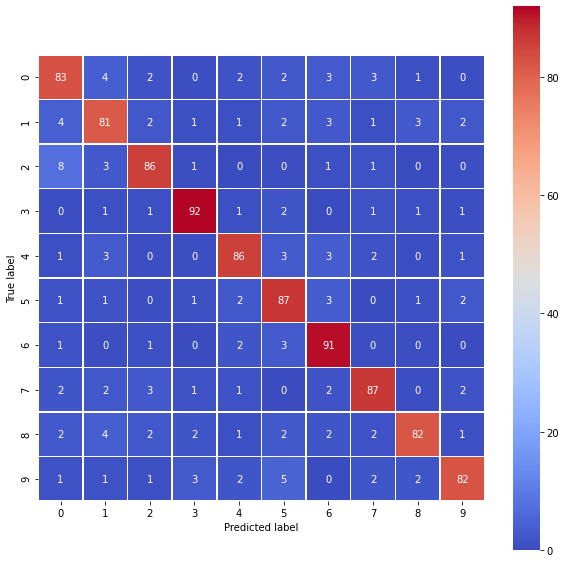

In [20]:
target_list_0 = distribution_of_prediction_0['target'].to_list()
prediction_list_0 = distribution_of_prediction_0['forecast_total'].to_list()

CM_0 = confusion_matrix(target_list_0, prediction_list_0)

CM_normalized_0 = CM_0.astype('float') / CM_0.sum(axis=1)[:, np.newaxis]*100
plt.subplots(figsize=(10, 10))
sn.heatmap(CM_normalized_0, annot=True, linewidths=.5, cmap='coolwarm', fmt='.0f', square=True);
plt.ylabel('True label');
plt.xlabel('Predicted label');

### Digit recognition

In [21]:
for data, target in test_MNIST_loader:
    
    prediction_val_1, prediction_idx_1, prediction_val_2, prediction_idx_2, target = forecast(model_digit, model_letter, data.to("cuda"), target.to("cuda"))

10000 images


In [22]:
distribution_of_prediction_1 = pd.DataFrame(list(zip(np.arange(len(prediction_val_1)),\
                            prediction_val_1, prediction_idx_1, prediction_val_2, prediction_idx_2, target)),\
                            columns=['item', 'val_1', 'idx_1', 'val_2', 'idx_2', 'target'])

distribution_of_prediction_1['forecast_1'] = distribution_of_prediction_1['idx_1']//20
distribution_of_prediction_1['forecast_2'] = distribution_of_prediction_1['idx_2']//20

distribution_of_prediction_1['forecast_total'] = 0

for i in range(distribution_of_prediction_1.shape[0]):
    if distribution_of_prediction_1['val_1'].loc[i] > distribution_of_prediction_1['val_2'].loc[i]:
        distribution_of_prediction_1['forecast_total'].loc[i] = distribution_of_prediction_1['forecast_1'].loc[i]
    else:
        distribution_of_prediction_1['forecast_total'].loc[i] = distribution_of_prediction_1['forecast_2'].loc[i]
        
right_1 = 0
wrong_1 = 0
for i in range(distribution_of_prediction_1.shape[0]):
    if distribution_of_prediction_1['forecast_total'].loc[i] == distribution_of_prediction_1['target'].loc[i]:
        right_1 += 1
    else:
        wrong_1 += 1
        
print(f'Accuracy of digit recognition by ensemble = {right_1 / (right_1 + wrong_1)*100 :.1f}%')

Accuracy of digit recognition by ensemble = 91.9%


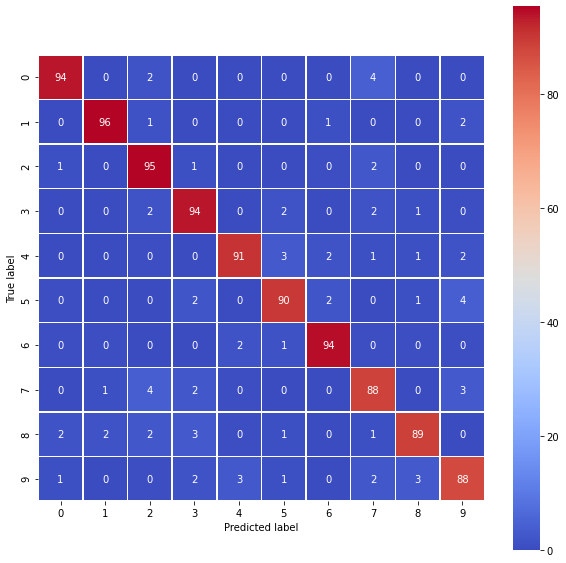

In [23]:
target_list_1 = distribution_of_prediction_1['target'].to_list()
prediction_list_1 = distribution_of_prediction_1['forecast_total'].to_list()

CM_1 = confusion_matrix(target_list_1, prediction_list_1)

CM_normalized_1 = CM_1.astype('float') / CM_1.sum(axis=1)[:, np.newaxis]*100
plt.subplots(figsize=(10, 10))
sn.heatmap(CM_normalized_1, annot=True, linewidths=.5, cmap='coolwarm', fmt='.0f', square=True);
plt.ylabel('True label');
plt.xlabel('Predicted label');

### Letter recognition

In [24]:
for data, target in test_letter_loader:
    
    prediction_val_1, prediction_idx_1, prediction_val_2, prediction_idx_2, target = forecast(model_digit, model_letter, data.to("cuda"), target.to("cuda"))

In [25]:
distribution_of_prediction_2 = pd.DataFrame(list(zip(np.arange(len(prediction_val_1)),\
                            prediction_val_1, prediction_idx_1, prediction_val_2, prediction_idx_2, target)),\
                            columns=['item', 'val_1', 'idx_1', 'val_2', 'idx_2', 'target'])

distribution_of_prediction_2['forecast_1'] = distribution_of_prediction_2['idx_1']//20
distribution_of_prediction_2['forecast_2'] = distribution_of_prediction_2['idx_2']//20

distribution_of_prediction_2['forecast_total'] = 0

for i in range(distribution_of_prediction_2.shape[0]):
    if distribution_of_prediction_2['val_1'].loc[i] > distribution_of_prediction_2['val_2'].loc[i]:
        distribution_of_prediction_2['forecast_total'].loc[i] = distribution_of_prediction_2['forecast_1'].loc[i]
    else:
        distribution_of_prediction_2['forecast_total'].loc[i] = distribution_of_prediction_2['forecast_2'].loc[i]
        
right_2 = 0
wrong_2 = 0
for i in range(distribution_of_prediction_2.shape[0]):
    if distribution_of_prediction_2['forecast_total'].loc[i] == distribution_of_prediction_2['target'].loc[i]:
        right_2 += 1
    else:
        wrong_2 += 1
        
print(f"Accuracy of letter recognition by ensemble = {right_2 / (right_2 + wrong_2)*100 :.1f}%")

Accuracy of letter recognition by ensemble = 79.6%


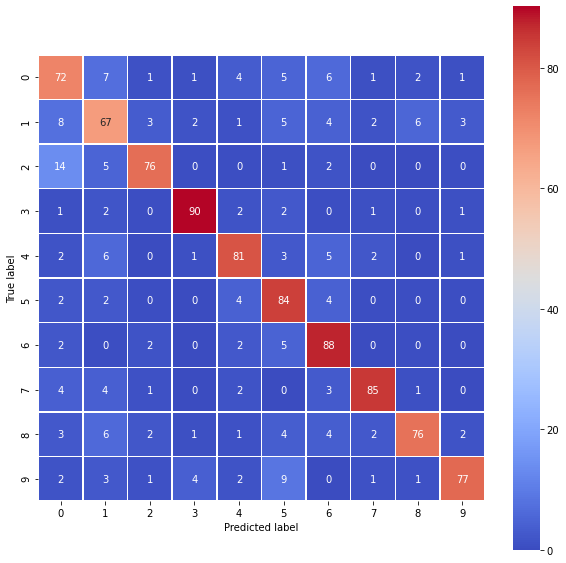

In [26]:
target_list_2 = distribution_of_prediction_2['target'].to_list()
prediction_list_2 = distribution_of_prediction_2['forecast_total'].to_list()

CM_2 = confusion_matrix(target_list_2, prediction_list_2)

CM_normalized_2 = CM_2.astype('float') / CM_2.sum(axis=1)[:, np.newaxis]*100
plt.subplots(figsize=(10, 10))
sn.heatmap(CM_normalized_2, annot=True, linewidths=.5, cmap='coolwarm', fmt='.0f', square=True);
plt.ylabel('True label');
plt.xlabel('Predicted label');